In [1]:
import glob
import os
import pandas as pd
import pprint
import re
import sklearn
from transfer.training_utils import load_model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
model_type = "l2lr"
os.chdir("/Users/jpgard/Documents/github/transfer_models")  # change wd because models path is hard-coded in transfer.training_utils.get_model_path()
models_dir = "./models/"
assert os.path.exists(models_dir), f"dir {models_dir} does not exist; check your working directory location."

In [12]:
model_files = glob.glob(os.path.join(models_dir, f"interaction_degree1_model_type{model_type}_src_institution*.pickle"))
pprint.pprint(model_files)

['./models/interaction_degree1_model_typel2lr_src_institutionum.pickle',
 './models/interaction_degree1_model_typel2lr_src_institutionasu.pickle',
 './models/interaction_degree1_model_typel2lr_src_institutionasuo.pickle',
 './models/interaction_degree1_model_typel2lr_src_institutionuci.pickle']


In [13]:
# Read the model files and extract their coefficients.

def extract_src_institution_from_uid(uid):
    return re.search(".*src_institution(\w+)", uid).group(1)

models = {}
for model_file in model_files:
    uid = re.search(".*/(.*)\\.pickle", model_file).group(1)
    model = load_model(uid)
    models[uid] = model

coefs = {extract_src_institution_from_uid(k): v.coef_.ravel().tolist() for k,v in models.items()}

2023-02-06 17:58:26 WARNING  loading model from ./models/interaction_degree1_model_typel2lr_src_institutionum.pickle using sklearn version 0.24.2If this is not the same version used to train the models this can leadto unexpected behavior!
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
2023-02-06 17:58:26 WARNING  loading model from ./models/interaction_degree1_model_typel2lr_src_institutionasu.pickle using sklearn version 0.24.2If this is not the same version used to train the models this can leadto unexpected behavior!
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 1.1.1 when using version 0.24.2. This might lead

In [15]:
metrics_dir = "./metrics/09.2022"
summary_df = pd.read_csv(os.path.join(metrics_dir, "um_train_descriptivestats_scaledFalse.csv"))
coef_names = pd.Series(summary_df.columns[1:]).reset_index().rename(columns={"index":"coef_idx"})

In [16]:

df = pd.DataFrame.from_dict(coefs).reset_index().rename(columns={"index":"coef_idx"})
df = df.melt(id_vars=['coef_idx'], 
             value_vars=["asuo", "asu", "uci", "um"])
df.rename(columns={"variable":"src_institution"}, inplace=True)
df = df.merge(coef_names, how="left", on="coef_idx").rename(columns={0: "variable_name"})
df.head()

,coef_idx,src_institution,value,variable_name
0,0,asuo,0.089044,act_english
1,1,asuo,0.052963,act_math
2,2,asuo,0.104219,age
3,3,asuo,0.000000,cip2_major_1_01
4,4,asuo,0.000000,cip2_major_1_02


In [17]:
# For each institution, print the top k largest-magnitude coefficients

k = 10
institutions = df.src_institution.unique().tolist()

for institution in institutions:
    print("Printing largest-magnitude coefficients for institution {} with model_type {}".format(
        institution, model_type))
    topk_df = df[df.src_institution == institution][["variable_name", "value"]]\
        .sort_values(by="value", key = abs, ascending=False)\
        .head(k)
    print(topk_df)
    print("\n")

Printing largest-magnitude coefficients for institution asuo with model_type l2lr
             variable_name     value
139         gpa_cumulative  1.411445
214     units_cip2_MISSING -0.792625
145               sat_math -0.639019
44         cip2_major_1_42  0.507727
238      units_type_others -0.491023
144              retention -0.454903
16         cip2_major_1_14 -0.451596
223  units_type_DIS-others -0.399955
11         cip2_major_1_09  0.395217
133     ethnicity_Hispanic  0.354489


Printing largest-magnitude coefficients for institution asu with model_type l2lr
          variable_name     value
383      gpa_cumulative  0.145089
386      gpa_zscore_avg  0.143675
382             gpa_avg  0.142033
458  units_cip2_MISSING -0.117066
482   units_type_others -0.071603
384     gpa_high_school  0.061236
395             sex_nan  0.046291
387   gpa_zscore_stddev -0.039710
460   units_incompleted  0.033112
385          gpa_stddev -0.026539


Printing largest-magnitude coefficients for institut

In [18]:
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

inst_pairs = [(x,y) for x,y in product(institutions,institutions) if x < y]

for x,y in inst_pairs:
    sim = cosine_similarity(np.array(coefs[x]).reshape((1,-1)), np.array(coefs[y]).reshape((1,-1)))
    print(f"inst {x} vs. inst {y} sim {sim}")

inst asuo vs. inst uci sim [[0.33703219]]
inst asuo vs. inst um sim [[0.2225624]]
inst asu vs. inst asuo sim [[0.46448893]]
inst asu vs. inst uci sim [[0.397752]]
inst asu vs. inst um sim [[0.26986666]]
inst uci vs. inst um sim [[0.17134966]]


In [19]:
# compute overlap@k

results = list()


for x,y in inst_pairs:
    coefs_x = df[df.src_institution == x][["variable_name", "value"]]
    coefs_x["abs_value"] = abs(coefs_x.value)
    coefs_y = df[df.src_institution == y][["variable_name", "value"]]  
    coefs_y["abs_value"] = abs(coefs_y.value)


    for k in range(len(coefs_x)):
        topk_x = coefs_x.nlargest(k, "abs_value").variable_name.tolist()
        topk_y = coefs_y.nlargest(k, "abs_value").variable_name.tolist()
        overlap = len(set(topk_x).intersection(set(topk_y)))
        results.append({"inst_x":x, "inst_y": y, "k": k, "overlap": overlap})
        # print(topk_x)
        # print(topk_y)
coefs_overlap = pd.DataFrame(results)
coefs_overlap.head()
coefs_overlap.to_csv("metrics/coefs_at_k.csv", index=False)

In [ ]:
# TODO: variable importances of ensembles
model_files = glob.glob(os.path.join(models_dir, f"model_type{model_type}_*.joblib"))
pprint.pprint(model_files)

# R code below

In [21]:
# !pip install rpy2

     |████████████████████████████████| 210 kB 2.6 MB/s eta 0:00:01
    ERROR: Command errored out with exit status 1:
     command: /Library/Frameworks/Python.framework/Versions/3.6/bin/python3 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T/pip-install-uq96_0so/rpy2_b2a5173376f8479c867cc5f80c6001c0/setup.py'"'"'; __file__='"'"'/private/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T/pip-install-uq96_0so/rpy2_b2a5173376f8479c867cc5f80c6001c0/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T/pip-pip-egg-info-s61rq89b
         cwd: /private/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T/pip-install-uq96_0so/rpy2_b2a517

     |████████████████████████████████| 201 kB 5.7 MB/s eta 0:00:01
    ERROR: Command errored out with exit status 1:
     command: /Library/Frameworks/Python.framework/Versions/3.6/bin/python3 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T/pip-install-uq96_0so/rpy2_5afd35d5cfa1406d9cdc258e04587e32/setup.py'"'"'; __file__='"'"'/private/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T/pip-install-uq96_0so/rpy2_5afd35d5cfa1406d9cdc258e04587e32/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T/pip-pip-egg-info-ojdrqqmk
         cwd: /private/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T/pip-install-uq96_0so/rpy2_5afd35

In [20]:
# Enable the %%R magic
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [98]:
%%R -i df
print(head(df))

install.packages("tidyverse")
install.packages("GGally")
install.packages("scales")
install.packages("ggallin")
library(scales)
library(ggallin)
library(GGally)
library(ggplot2)

  coef_idx src_institution         value   variable_name
0        0            asuo -2.508635e-05     act_english
1        1            asuo  1.244466e-02        act_math
2        2            asuo  2.654869e-02             age
3        3            asuo  0.000000e+00 cip2_major_1_01
4        4            asuo  0.000000e+00 cip2_major_1_02
5        5            asuo -9.040590e-03 cip2_major_1_03

  There is a binary version available but the source version is later:
          binary source needs_compilation
tidyverse  1.3.0  1.3.1             FALSE



2022-01-13 14:34:10 WARNING  R[write to console]: installing the source package ‘tidyverse’


2022-01-13 14:34:10 WARNING  R[write to console]: trying URL 'https://ftp.osuosl.org/pub/cran/src/contrib/tidyverse_1.3.1.tar.gz'

2022-01-13 14:34:11 WARNING  R[write to console]: Content type 'application/x-gzip'
2022-01-13 14:34:11 WARNING  R[write to console]:  length 702779 bytes (686 KB)

2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write to console]: =
2022-01-13 14:34:11 WARNING  R[write t


  There is a binary version available but the source version is later:
       binary source needs_compilation
GGally  1.4.0  2.1.2             FALSE



2022-01-13 14:34:16 WARNING  R[write to console]: installing the source package ‘GGally’


2022-01-13 14:34:16 WARNING  R[write to console]: trying URL 'https://ftp.osuosl.org/pub/cran/src/contrib/GGally_2.1.2.tar.gz'

2022-01-13 14:34:16 WARNING  R[write to console]: Content type 'application/x-gzip'
2022-01-13 14:34:16 WARNING  R[write to console]:  length 1432522 bytes (1.4 MB)

2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to console]: =
2022-01-13 14:34:17 WARNING  R[write to con


  There is a binary version available but the source version is later:
       binary source needs_compilation
scales  1.1.0  1.1.1             FALSE



2022-01-13 14:34:25 WARNING  R[write to console]: installing the source package ‘scales’


2022-01-13 14:34:25 WARNING  R[write to console]: trying URL 'https://ftp.osuosl.org/pub/cran/src/contrib/scales_1.1.1.tar.gz'

2022-01-13 14:34:25 WARNING  R[write to console]: Content type 'application/x-gzip'
2022-01-13 14:34:25 WARNING  R[write to console]:  length 515201 bytes (503 KB)

2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to console]: =
2022-01-13 14:34:25 WARNING  R[write to cons


The downloaded binary packages are in
	/var/folders/3f/96kfmy7s1y5_5fr8cgqtfzpm0000gn/T//RtmpSqoi9e/downloaded_packages


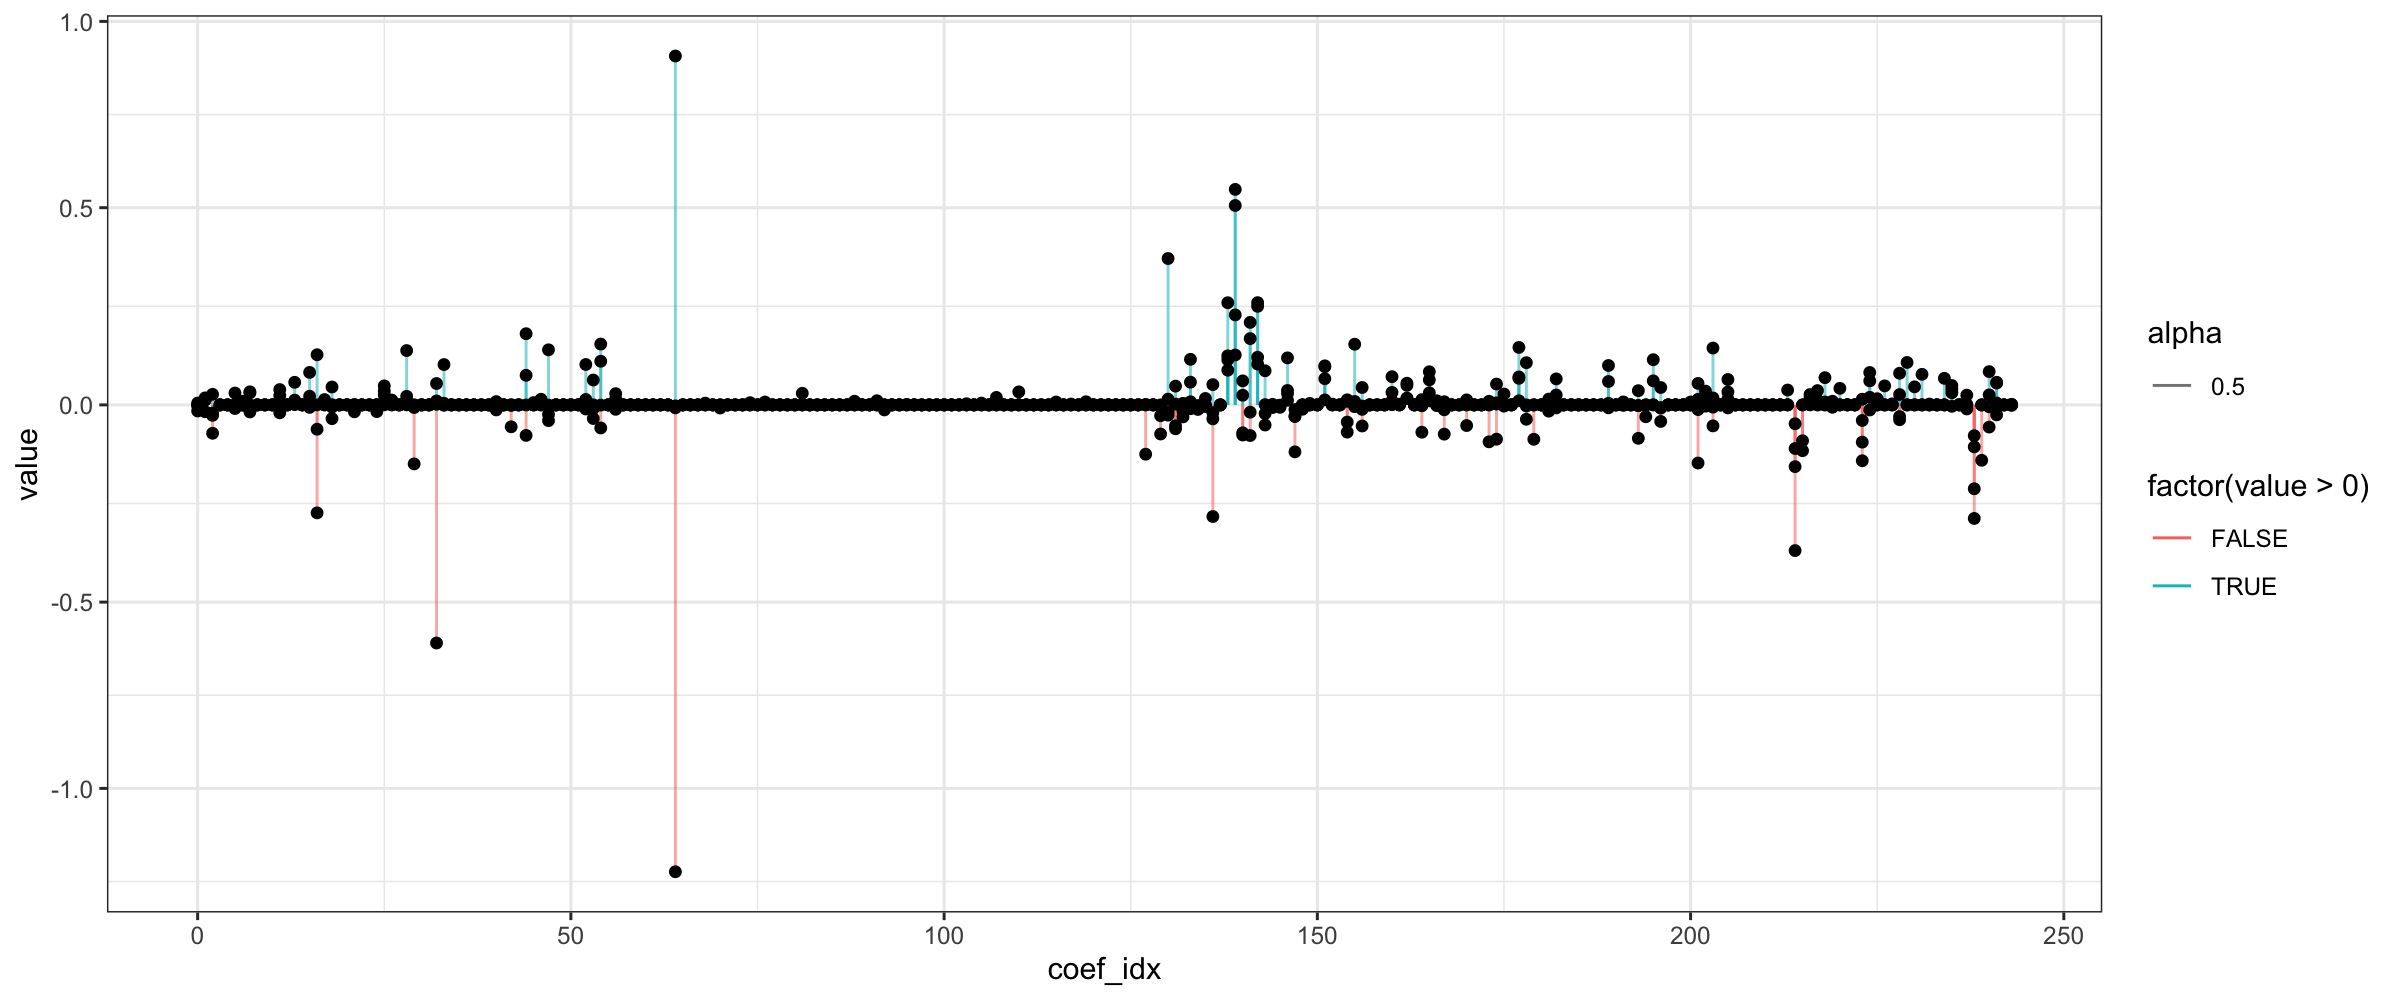

In [101]:
%%R -i df -w 12 -h 5 --units in -r 200

ggplot(df, aes(y=value, x=coef_idx, group=src_institution,)
      )  + geom_segment(
            aes(y=0, yend=value,x=coef_idx, xend=coef_idx, alpha=0.5, color=factor(value>0))
      ) + geom_point(
      ) + theme_bw(
      ) + scale_y_continuous(trans=pseudolog10_trans)

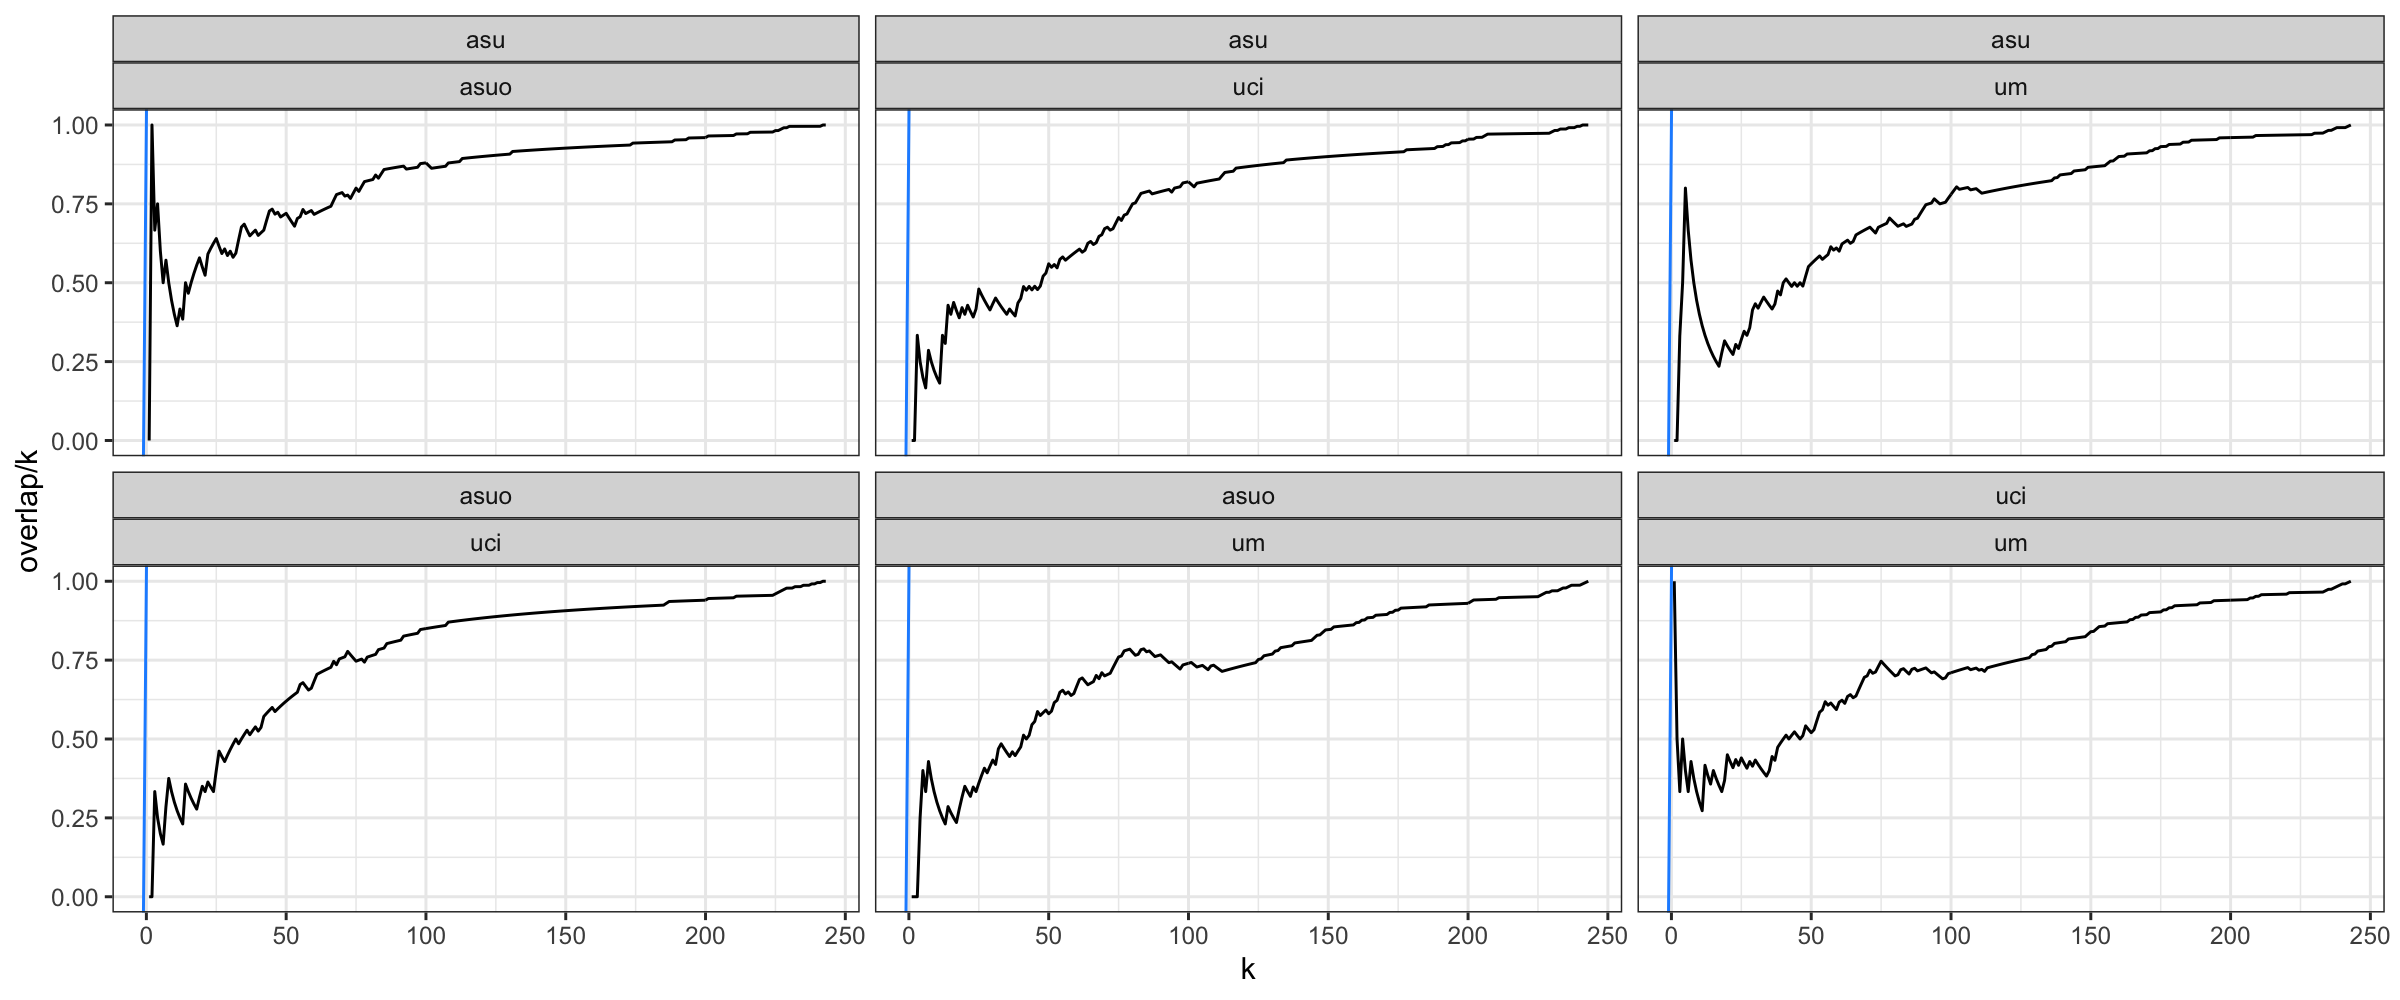

In [118]:
%%R -i coefs_overlap -w 12 -h 5 --units in -r 200

ggplot(coefs_overlap, aes(x=k, y=overlap/k)
      ) + geom_line() + geom_abline(slope=1, intercept=1, color="dodgerblue") + facet_wrap(inst_x ~ inst_y) + theme_bw()

2022-01-12 21:27:29 WARNING  R[write to console]: 
2022-01-12 21:27:29 WARNING  R[write to console]:  plot: [1,1] [==>-----------------------------------------------]  6% est: 0s 
2022-01-12 21:27:29 WARNING  R[write to console]: 
2022-01-12 21:27:29 WARNING  R[write to console]:  plot: [1,2] [=====>--------------------------------------------] 12% est: 0s 
2022-01-12 21:27:29 WARNING  R[write to console]: 
2022-01-12 21:27:29 WARNING  R[write to console]:  plot: [1,3] [========>-----------------------------------------] 19% est: 1s 
2022-01-12 21:27:29 WARNING  R[write to console]: 
2022-01-12 21:27:29 WARNING  R[write to console]:  plot: [1,4] [===========>--------------------------------------] 25% est: 1s 
2022-01-12 21:27:29 WARNING  R[write to console]: 
2022-01-12 21:27:29 WARNING  R[write to console]:  plot: [2,1] [===============>----------------------------------] 31% est: 1s 
2022-01-12 21:27:29 WARNING  R[write to console]: 
2022-01-12 21:27:29 WARNING  R[write to console]:

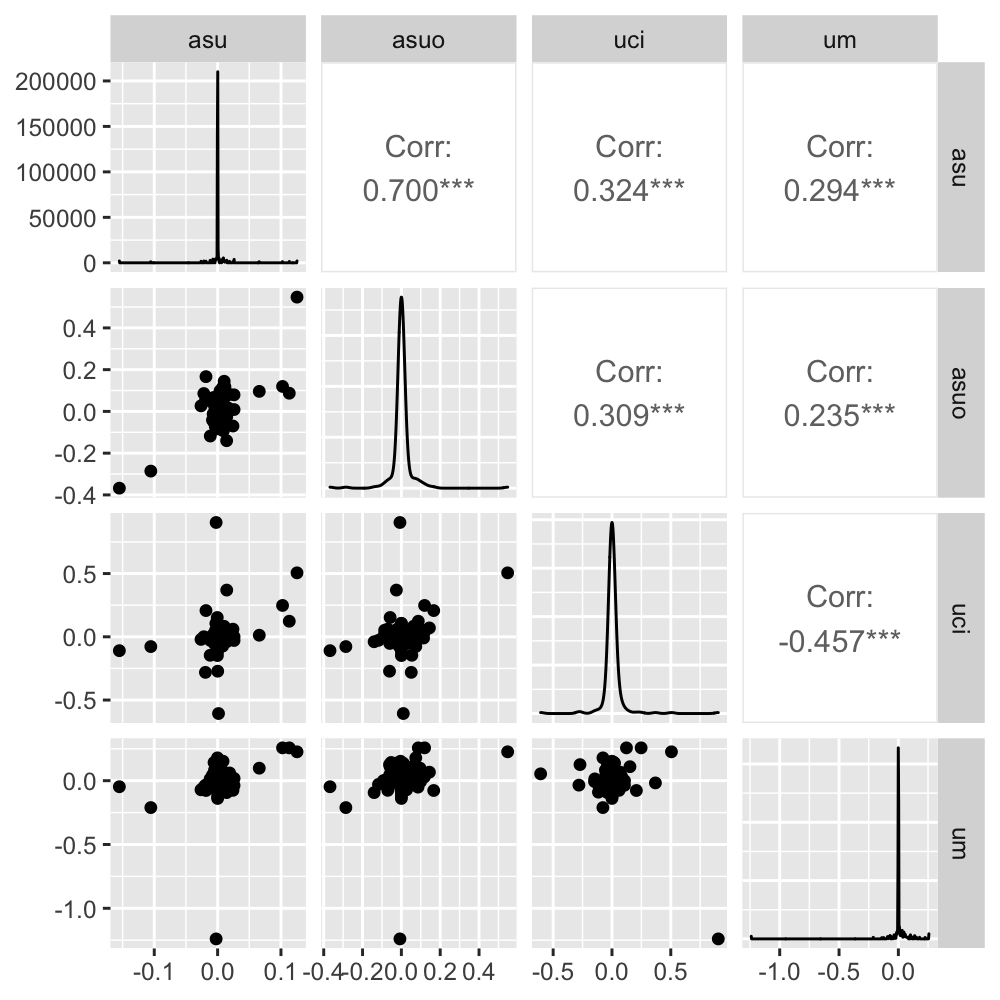

In [36]:
%%R -i df -w 5 -h 5 --units in -r 200

ggpairs(tidyr::spread(df, key="src_institution", value="value")[,-1])